In [1]:
import pandas as pd
import numpy as np

import geopandas as gpd
from shapely.geometry import Point
import rtree
import pickle

import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

## Event Listing

In [2]:
event_list_df = pd.read_csv("data/NYC_Parks_Events_Listing___Event_Listing.csv", parse_dates=True)

In [3]:
event_list_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68689 entries, 0 to 68688
Data columns (total 15 columns):
event_id                68689 non-null int64
title                   68689 non-null object
date                    68689 non-null object
start_time              68689 non-null object
end_time                68689 non-null object
location_description    13059 non-null object
description             68685 non-null object
snippet                 68385 non-null object
phone                   53482 non-null object
email                   47694 non-null object
cost_free               68689 non-null int64
cost_description        13807 non-null object
must_see                68689 non-null int64
url                     68687 non-null object
notice                  68689 non-null int64
dtypes: int64(4), object(11)
memory usage: 7.9+ MB


In [4]:
event_list_df['start_time'] = pd.to_datetime(event_list_df['start_time'], format='%H:%M')

In [5]:
event_list_df[event_list_df.end_time == '24:00']

,event_id,title,date,start_time,end_time,location_description,description,snippet,phone,email,cost_free,cost_description,must_see,url,notice
11088,79666,New Year's Eve Fireworks in Prospect Park,12/31/2013,1900-01-01 23:00:00,24:00,NaN,<p>\n\tStart the celebrations off around 11 p....,Start the celebrations off around 11 p.m. with...,NaN,NaN,1,NaN,1,new-years-eve-fireworks1,0
23359,102431,New Year's Eve Fireworks,12/31/2014,1900-01-01 23:00:00,24:00,NaN,<p>Kick off the New Year&#39;s with this belov...,Kick off the New Year's with this beloved Broo...,NaN,NaN,1,NaN,1,new-years-eve-fireworks,0


In [6]:
event_list_df = event_list_df.drop(event_list_df.index[23359])
event_list_df = event_list_df.drop(event_list_df.index[11088])

In [7]:
event_list_df[event_list_df.end_time == '24:00']

,event_id,title,date,start_time,end_time,location_description,description,snippet,phone,email,cost_free,cost_description,must_see,url,notice


In [8]:
event_list_df['end_time'] = pd.to_datetime(event_list_df['end_time'], format='%H:%M')

In [9]:
event_list_df['date'] = pd.to_datetime(event_list_df.date)

In [10]:
event_list_df['is_event'] = 1

In [11]:
event_list_df.end_time[40]

Timestamp('1900-01-01 15:00:00')

In [12]:
event_list_df.start_time[40]

Timestamp('1900-01-01 13:00:00')

In [13]:
event_list_df['event_duration'] = ((event_list_df.end_time-event_list_df.start_time).dt.total_seconds())/60

In [14]:
str(event_list_df.start_time.dt.time[0]).split(":")[0]

'11'

In [16]:
for index, event in event_list_df.iterrows():
    start = int(str(event_list_df.start_time.dt.time[index]).split(":")[0])
    end = int(str(event_list_df.end_time.dt.time[index]).split(":")[0])
    
    if(((start >= 3) & (start < 13)) | ((end >= 3) & (end < 13))):
        event_list_df.loc[[index],'morning'] = 1
    else:
        event_list_df.loc[[index],'morning'] = 0
        
    if(((start >= 13) & (start < 18)) | ((end >= 13) & (end < 18))):
        event_list_df.loc[[index],'afternoon'] = 1
    else:
        event_list_df.loc[[index],'afternoon'] = 0
        
    if(((start >= 18) & (start < 3)) | ((end >= 18) & (end < 3))):
        event_list_df.loc[[index],'night'] = 1
    else:
        event_list_df.loc[[index],'night'] = 0

In [20]:
f = open('storage/event_list_df.pckl', 'wb')
pickle.dump(event_list_df, f)
f.close()

In [25]:
f = open('storage/event_list_df.pckl', 'rb')
event_list_df = pickle.load(f)
f.close()

In [26]:
agg_df = event_list_df[event_list_df.date.dt.year == 2017]

In [24]:
agg_df.head()

,event_id,title,date,start_time,end_time,location_description,description,snippet,phone,email,cost_free,cost_description,must_see,url,notice,is_event,event_duration,morning,afternoon,night
26877,107941,Conference House Art Expo 2017,2017-05-20,1900-01-01 11:00:00,1900-01-01 17:00:00,NaN,<p>Come view original artworks and tree instal...,Come view original artworks and tree installat...,(718) 984-6046,admin@conferencehouse.org,1,NaN,0,resiliency-and-elements,0,1,360.0,1.0,1.0,0.0
27651,108867,Thursday Evening Hours at the Merchant’s House...,2017-01-05,1900-01-01 12:00:00,1900-01-01 20:00:00,NaN,"<p>Beginning May 7, 2015, the Merchant’s House...","Beginning May 7, 2015, the Merchant’s House Mu...",(212) 777-1089,emily@merchantshouse.org,0,"Admission is $10, $5 seniors & students, Free ...",0,thursday-evening-hours-at-the-merchants-house-...,0,1,480.0,1.0,0.0,0.0
27652,108868,Thursday Evening Hours at the Merchant’s House...,2017-01-12,1900-01-01 12:00:00,1900-01-01 20:00:00,NaN,"<p>Beginning May 7, 2015, the Merchant’s House...","Beginning May 7, 2015, the Merchant’s House Mu...",(212) 777-1089,emily@merchantshouse.org,0,"Admission is $10, $5 seniors & students, Free ...",0,thursday-evening-hours-at-the-merchants-house-...,0,1,480.0,1.0,0.0,0.0
27653,108869,Thursday Evening Hours at the Merchant’s House...,2017-01-19,1900-01-01 12:00:00,1900-01-01 20:00:00,NaN,"<p>Beginning May 7, 2015, the Merchant’s House...","Beginning May 7, 2015, the Merchant’s House Mu...",(212) 777-1089,emily@merchantshouse.org,0,"Admission is $10, $5 seniors & students, Free ...",0,thursday-evening-hours-at-the-merchants-house-...,0,1,480.0,1.0,0.0,0.0
27654,108870,Thursday Evening Hours at the Merchant’s House...,2017-01-26,1900-01-01 12:00:00,1900-01-01 20:00:00,NaN,"<p>Beginning May 7, 2015, the Merchant’s House...","Beginning May 7, 2015, the Merchant’s House Mu...",(212) 777-1089,emily@merchantshouse.org,0,"Admission is $10, $5 seniors & students, Free ...",0,thursday-evening-hours-at-the-merchants-house-...,0,1,480.0,1.0,0.0,0.0


In [ ]:
plt.hist(agg_df.event_duration, bins=50);

In [ ]:
plt.plot(agg_df.event_id);

## Event Location

In [27]:
loc_df = pd.read_csv('data/NYC_Parks_Events_Listing___Event_Locations.csv')

In [28]:
loc_df.head()

,event_id,name,park_id,lat,long,address,zip,borough,accessible,Location 1
0,62223,Watson Building,X002,40.8624,-73.880501,NaN,NaN,X,NaN,"(40.86240005493164000, -73.88050079345703000)"
1,62224,Watson Building,X002,40.8624,-73.880501,NaN,NaN,X,NaN,"(40.86240005493164000, -73.88050079345703000)"
2,62225,Watson Building,X002,40.8624,-73.880501,NaN,NaN,X,NaN,"(40.86240005493164000, -73.88050079345703000)"
3,62226,Watson Building,X002,40.8624,-73.880501,NaN,NaN,X,NaN,"(40.86240005493164000, -73.88050079345703000)"
4,62227,Watson Building,X002,40.8624,-73.880501,NaN,NaN,X,NaN,"(40.86240005493164000, -73.88050079345703000)"


In [29]:
loc_df.shape

(87092, 10)

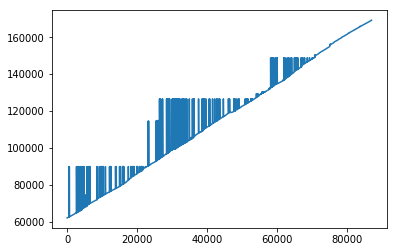

In [30]:
plt.plot(loc_df.event_id)

In [31]:
loc_df[loc_df.event_id == 141581]

,event_id,name,park_id,lat,long,address,zip,borough,accessible,Location 1
65098,141581,Gracie Mansion,M081,40.776001,-73.9431,"88th Street & East End Avenue, Carl Schurz Park",10007.0,M,NaN,"(40.77600097656250000, -73.94309997558594000)"


In [32]:
loc_df[loc_df.event_id == 62223]

,event_id,name,park_id,lat,long,address,zip,borough,accessible,Location 1
0,62223,Watson Building,X002,40.8624,-73.880501,NaN,NaN,X,NaN,"(40.86240005493164000, -73.88050079345703000)"


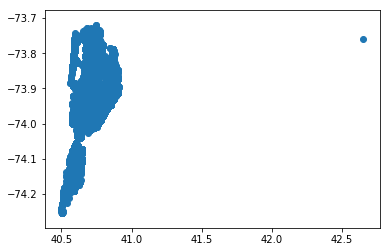

In [33]:
plt.scatter(loc_df.lat, loc_df.long)

https://towardsdatascience.com/geospatial-operations-at-scale-with-dask-and-geopandas-4d92d00eb7e8

In [34]:
df = gpd.read_file('data/taxizones/taxi_zones.shp').to_crs({'init': 'epsg:4326'})
df = df.drop(['Shape_Area', 'Shape_Leng', 'OBJECTID'], axis=1)
gpd.sjoin(gpd.GeoDataFrame(crs={'init': 'epsg:4326'},
    geometry=[Point(-73.9431, 40.776001)]), 
    df, how='left', op='within')

,geometry,index_right,zone,LocationID,borough
0,POINT (-73.9431 40.776001),261,Yorkville East,262,Manhattan


In [35]:
def assign_taxi_zones(df, lon_var, lat_var, locid_var):
    """Joins DataFrame with Taxi Zones shapefile.
    This function takes longitude values provided by `lon_var`, and latitude
    values provided by `lat_var` in DataFrame `df`, and performs a spatial join
    with the NYC taxi_zones shapefile. 
    The shapefile is hard coded in, as this function makes a hard assumption of
    latitude and longitude coordinates. It also assumes latitude=0 and 
    longitude=0 is not a datapoint that can exist in your dataset. Which is 
    reasonable for a dataset of New York, but bad for a global dataset.
    Only rows where `df.lon_var`, `df.lat_var` are reasonably near New York,
    and `df.locid_var` is set to np.nan are updated. 
    Parameters
    ----------
    df : pandas.DataFrame or dask.DataFrame
        DataFrame containing latitudes, longitudes, and location_id columns.
    lon_var : string
        Name of column in `df` containing longitude values. Invalid values 
        should be np.nan.
    lat_var : string
        Name of column in `df` containing latitude values. Invalid values 
        should be np.nan
    locid_var : string
        Name of series to return. 
    """

    import geopandas
    from shapely.geometry import Point


    # make a copy since we will modify lats and lons
    localdf = df[[lon_var, lat_var]].copy()
    
    # missing lat lon info is indicated by nan. Fill with zero
    # which is outside New York shapefile. 
    localdf[lon_var] = localdf[lon_var].fillna(value=0.)
    localdf[lat_var] = localdf[lat_var].fillna(value=0.)
    

    shape_df = geopandas.read_file('data/taxizones/taxi_zones.shp')
    shape_df.drop(['OBJECTID', "Shape_Area", "Shape_Leng", "borough", "zone"],
                  axis=1, inplace=True)
    shape_df = shape_df.to_crs({'init': 'epsg:4326'})

    try:
        local_gdf = geopandas.GeoDataFrame(
            localdf, crs={'init': 'epsg:4326'},
            geometry=[Point(xy) for xy in
                      zip(localdf[lon_var], localdf[lat_var])])

        local_gdf = geopandas.sjoin(
            local_gdf, shape_df, how='left', op='within')
#         return local_gdf
        return local_gdf.LocationID.rename(locid_var)
    except ValueError as ve:
        print(ve)
        print(ve.stacktrace())
        series = localdf[lon_var]
        series = np.nan
    return series

In [36]:
loc_df['taxi_zone'] = assign_taxi_zones(loc_df, 'long', 'lat', 'taxi_zones')

In [37]:
loc_df[loc_df.taxi_zone == np.inf]

,event_id,name,park_id,lat,long,address,zip,borough,accessible,Location 1,taxi_zone


In [38]:
loc_df['taxi_zone'] = loc_df.taxi_zone.fillna(0).astype(int)

In [39]:
loc_df.head()

,event_id,name,park_id,lat,long,address,zip,borough,accessible,Location 1,taxi_zone
0,62223,Watson Building,X002,40.8624,-73.880501,NaN,NaN,X,NaN,"(40.86240005493164000, -73.88050079345703000)",31
1,62224,Watson Building,X002,40.8624,-73.880501,NaN,NaN,X,NaN,"(40.86240005493164000, -73.88050079345703000)",31
2,62225,Watson Building,X002,40.8624,-73.880501,NaN,NaN,X,NaN,"(40.86240005493164000, -73.88050079345703000)",31
3,62226,Watson Building,X002,40.8624,-73.880501,NaN,NaN,X,NaN,"(40.86240005493164000, -73.88050079345703000)",31
4,62227,Watson Building,X002,40.8624,-73.880501,NaN,NaN,X,NaN,"(40.86240005493164000, -73.88050079345703000)",31


## Merge Event and Event Locations and Taxi

In [40]:
merged_df = pd.merge(agg_df, loc_df, on=['event_id'])

In [41]:
merged_df.head()

,event_id,title,date,start_time,end_time,location_description,description,snippet,phone,email,cost_free,cost_description,must_see,url,notice,is_event,event_duration,morning,afternoon,night,name,park_id,lat,long,address,zip,borough,accessible,Location 1,taxi_zone
0,107941,Conference House Art Expo 2017,2017-05-20,1900-01-01 11:00:00,1900-01-01 17:00:00,NaN,<p>Come view original artworks and tree instal...,Come view original artworks and tree installat...,(718) 984-6046,admin@conferencehouse.org,1,NaN,0,resiliency-and-elements,0,1,360.0,1.0,1.0,0.0,Conference House Park Visitor Center,R006,40.502602,-74.251801,298 Satterlee Street,NaN,R,1.0,"(40.50260162353500000, -74.25180053710900000)",44
1,108867,Thursday Evening Hours at the Merchant’s House...,2017-01-05,1900-01-01 12:00:00,1900-01-01 20:00:00,NaN,"<p>Beginning May 7, 2015, the Merchant’s House...","Beginning May 7, 2015, the Merchant’s House Mu...",(212) 777-1089,emily@merchantshouse.org,0,"Admission is $10, $5 seniors & students, Free ...",0,thursday-evening-hours-at-the-merchants-house-...,0,1,480.0,1.0,0.0,0.0,Merchant's House Museum,M318,40.727699,-73.992302,29 East 4th Street,10003.0,M,0.0,"(40.72769927978515600, -73.99230194091797000)",113
2,108868,Thursday Evening Hours at the Merchant’s House...,2017-01-12,1900-01-01 12:00:00,1900-01-01 20:00:00,NaN,"<p>Beginning May 7, 2015, the Merchant’s House...","Beginning May 7, 2015, the Merchant’s House Mu...",(212) 777-1089,emily@merchantshouse.org,0,"Admission is $10, $5 seniors & students, Free ...",0,thursday-evening-hours-at-the-merchants-house-...,0,1,480.0,1.0,0.0,0.0,Merchant's House Museum,M318,40.727699,-73.992302,29 East 4th Street,10003.0,M,0.0,"(40.72769927978515600, -73.99230194091797000)",113
3,108869,Thursday Evening Hours at the Merchant’s House...,2017-01-19,1900-01-01 12:00:00,1900-01-01 20:00:00,NaN,"<p>Beginning May 7, 2015, the Merchant’s House...","Beginning May 7, 2015, the Merchant’s House Mu...",(212) 777-1089,emily@merchantshouse.org,0,"Admission is $10, $5 seniors & students, Free ...",0,thursday-evening-hours-at-the-merchants-house-...,0,1,480.0,1.0,0.0,0.0,Merchant's House Museum,M318,40.727699,-73.992302,29 East 4th Street,10003.0,M,0.0,"(40.72769927978515600, -73.99230194091797000)",113
4,108870,Thursday Evening Hours at the Merchant’s House...,2017-01-26,1900-01-01 12:00:00,1900-01-01 20:00:00,NaN,"<p>Beginning May 7, 2015, the Merchant’s House...","Beginning May 7, 2015, the Merchant’s House Mu...",(212) 777-1089,emily@merchantshouse.org,0,"Admission is $10, $5 seniors & students, Free ...",0,thursday-evening-hours-at-the-merchants-house-...,0,1,480.0,1.0,0.0,0.0,Merchant's House Museum,M318,40.727699,-73.992302,29 East 4th Street,10003.0,M,0.0,"(40.72769927978515600, -73.99230194091797000)",113


In [42]:
merged_df['date'] = pd.to_datetime(merged_df.date).dt.date

In [43]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12043 entries, 0 to 12042
Data columns (total 30 columns):
event_id                12043 non-null int64
title                   12043 non-null object
date                    12043 non-null object
start_time              12043 non-null datetime64[ns]
end_time                12043 non-null datetime64[ns]
location_description    2392 non-null object
description             12043 non-null object
snippet                 12039 non-null object
phone                   8745 non-null object
email                   8151 non-null object
cost_free               12043 non-null int64
cost_description        1953 non-null object
must_see                12043 non-null int64
url                     12041 non-null object
notice                  12043 non-null int64
is_event                12043 non-null int64
event_duration          12043 non-null float64
morning                 12043 non-null float64
afternoon               12043 non-null float64
night  

In [56]:
data = merged_df.merge(taxi_df, on=['date', 'taxi_zone'], how='right')

In [57]:
data.isnull().sum()

event_id                  9170
title                     9170
date                         0
start_time                9170
end_time                  9170
location_description     10215
description               9170
snippet                   9172
phone                     9601
email                     9576
cost_free                 9170
cost_description         10332
must_see                  9170
url                       9170
notice                    9170
is_event                  9170
event_duration            9170
morning                   9170
afternoon                 9170
night                     9170
name                      9170
park_id                   9399
lat                       9170
long                      9170
address                   9846
zip                       9715
borough                   9196
accessible                9850
Location 1                9170
taxi_zone                    0
VendorID                     0
lpep_pickup_datetime         0
lpep_dro

In [58]:
data.is_event.isnull().sum()

9170

In [59]:
data['is_event'] = data.is_event.fillna(0)

In [101]:
data.is_event.value_counts()

0.0    9170
1.0    1288
Name: is_event, dtype: int64

In [60]:
data.head()

,event_id,title,date,start_time,end_time,location_description,description,snippet,phone,email,cost_free,cost_description,must_see,url,notice,is_event,event_duration,morning,afternoon,night,name,park_id,lat,long,address,zip,borough,accessible,Location 1,taxi_zone,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,taxi_duration
0,139176.0,Shape Up NYC: Zumba - Adults,2017-12-09,1900-01-01 10:00:00,1900-01-01 11:00:00,NaN,"<p>Have fun with Zumba for fitness, health, an...","Have fun with Zumba for fitness, health, and w...",(718) 365-5516,Lucy.Aponte@parks.nyc.gov,1.0,NaN,0.0,shape-up-zumbaadults,0.0,1.0,60.0,1.0,0.0,0.0,Poe Park Visitor Center,X040,40.865002,-73.894699,2640 Grand Concourse,NaN,X,1.0,"(40.86500167846680000, -73.89469909667969000)",18,2,2017-12-09 16:08:09,2017-12-09 16:39:12,N,1,74,1,6.52,24.0,0.0,0.5,0.0,0.0,NaN,0.3,24.8,2,1,31.0
1,156190.0,Adults Create Your Own Holiday Wrapping Paper,2017-12-09,1900-01-01 14:00:00,1900-01-01 15:30:00,NaN,"<p>Adults will make their own, creative gift w...","Adults will make their own, creative gift wrap...",(718) 365-5516,Lucy.Aponte@parks.nyc.gov,1.0,NaN,0.0,adults-create-your-own-holiday-wrapping-paper,0.0,1.0,90.0,0.0,1.0,0.0,Poe Park Visitor Center,X040,40.865002,-73.894699,2640 Grand Concourse,NaN,X,1.0,"(40.86500167846680000, -73.89469909667969000)",18,2,2017-12-09 16:08:09,2017-12-09 16:39:12,N,1,74,1,6.52,24.0,0.0,0.5,0.0,0.0,NaN,0.3,24.8,2,1,31.0
2,156283.0,Kids Paper Arts and Crafts,2017-12-09,1900-01-01 14:00:00,1900-01-01 15:30:00,NaN,<p>Kids have fun creating art out of paper.</p...,Kids have fun creating art out of paper.,(718) 365-5516,Lucy.Aponte@parks.nyc.gov,1.0,NaN,0.0,kids-paper-arts-and-crafts,0.0,1.0,90.0,0.0,1.0,0.0,Poe Park Visitor Center,X040,40.865002,-73.894699,2640 Grand Concourse,NaN,X,1.0,"(40.86500167846680000, -73.89469909667969000)",18,2,2017-12-09 16:08:09,2017-12-09 16:39:12,N,1,74,1,6.52,24.0,0.0,0.5,0.0,0.0,NaN,0.3,24.8,2,1,31.0
3,157056.0,Whimsical Winter Wonder...Exhibition Opening R...,2017-12-09,1900-01-01 12:00:00,1900-01-01 15:30:00,NaN,<p>The Poe Park Visitor Center proudly present...,"The exhibition, curated by Lucy Aponte, featur...",(718) 365-5516,Lucy.Aponte@parks.nyc.gov,1.0,NaN,0.0,whimsical-winter-wonderexhibition-opening-rece...,0.0,1.0,210.0,1.0,1.0,0.0,Poe Park Visitor Center,X040,40.865002,-73.894699,2640 Grand Concourse,NaN,X,1.0,"(40.86500167846680000, -73.89469909667969000)",18,2,2017-12-09 16:08:09,2017-12-09 16:39:12,N,1,74,1,6.52,24.0,0.0,0.5,0.0,0.0,NaN,0.3,24.8,2,1,31.0
4,157659.0,Fifth Annual Whimsical Winter Wonder... Exhibi...,2017-12-09,1900-01-01 09:00:00,1900-01-01 17:00:00,NaN,<p>The Poe Park Visitor Center proudly present...,"The exhibition, curated by Lucy Aponte, featur...",(718) 365-55169,Lucy.Aponte@parks.nyc.gov,1.0,NaN,0.0,5th-annual-whimsical-winter-wonder-exhibition,0.0,1.0,480.0,1.0,1.0,0.0,Poe Park Visitor Center,X040,40.865002,-73.894699,2640 Grand Concourse,NaN,X,1.0,"(40.86500167846680000, -73.89469909667969000)",18,2,2017-12-09 16:08:09,2017-12-09 16:39:12,N,1,74,1,6.52,24.0,0.0,0.5,0.0,0.0,NaN,0.3,24.8,2,1,31.0


In [ ]:
# data.groupby(['date', 'taxi_zone', 'is_event'])[['trip_distance']].mean()

In [ ]:
# data.groupby(['date', 'taxi_zone']).count()

In [99]:
test = data.groupby(['taxi_zone', 'is_event', 'afternoon'])[['VendorID']].count()

In [100]:
test.unstack().unstack()

VendorID      
afternoon      0.0   1.0
is_event       1.0   1.0
taxi_zone               
4              NaN   1.0
7              4.0   1.0
14             4.0   NaN
15             1.0   5.0
17            13.0  11.0
18            11.0  44.0
19             NaN   1.0
20             NaN   1.0
24             2.0   NaN
28             NaN   3.0
32             1.0   NaN
33           100.0  25.0
35             1.0   3.0
36             1.0   3.0
37             2.0   6.0
39             4.0   2.0
40             2.0   NaN
41             2.0   6.0
42            25.0  27.0
43            58.0  61.0
47             1.0   NaN
49             NaN   3.0
50             NaN   1.0
54             7.0   NaN
55             2.0   NaN
56             NaN   4.0
60             NaN   1.0
61             8.0  10.0
63             1.0   1.0
65             2.0   NaN
66            10.0   1.0
68             1.0   1.0
72             NaN   1.0
74            63.0  28.0
75             5.0   6.0
79             NaN   4.0
80             3.0   2.0
82             7.0   1.0
92             5.0  20.0
93             6.0   6.0
95             1.0   NaN
97            42.0  26.0
98             1.0   NaN
106            NaN   1.0
107            4.0   1.0
112            4.0   4.0
114            9.0   2.0
116           30.0  21.0
119            4.0   NaN
127            1.0   1.0
128            2.0   NaN
129            5.0   NaN
130            NaN   1.0
133            1.0   NaN
140            1.0   NaN
142            NaN   1.0
143            3.0   1.0
145            3.0   4.0
148            NaN   2.0
150            1.0   NaN
151            1.0   NaN
152            9.0   5.0
158            2.0   NaN
160            NaN   2.0
163            NaN   3.0
164           18.0   9.0
166           20.0   7.0
168           22.0  12.0
170            3.0   NaN
174            NaN   2.0
177            1.0   NaN
179            3.0   2.0
181           15.0   8.0
186            1.0   NaN
188            NaN   1.0
190            7.0  14.0
193            3.0   7.0
194            1.0   2.0
195            2.0   5.0
196            2.0   1.0
197            1.0   NaN
200            1.0   4.0
205            1.0   1.0
206            NaN   1.0
208            1.0   NaN
210            NaN   1.0
213            1.0   NaN
220            1.0   NaN
223            9.0   NaN
225           22.0   4.0
226            1.0   NaN
227            NaN   1.0
228            2.0   NaN
229            3.0   NaN
232            2.0   1.0
234            6.0  10.0
236            2.0   NaN
237            5.0   4.0
238           25.0   2.0
239           16.0   2.0
241            NaN   1.0
243           32.0   9.0
244           19.0  19.0
246           10.0   NaN
247            1.0   1.0
249            2.0   NaN
255           12.0  19.0
256            NaN   2.0
260            6.0   NaN
262           10.0   6.0

In [80]:
test.values.flatten()

array([ 1,  4,  4,  3,  8, 22,  1,  2,  1, 39,  2,  3,  3,  2, 20, 34,  1,
        4,  2, 10,  1,  1,  2,  2,  1, 60,  7,  3,  4,  5, 18,  6, 28,  3,
        4,  5, 10,  4,  4,  1,  1,  2,  4,  1,  1,  5,  1,  3, 12,  9,  9,
        1,  2, 17,  1, 10,  8,  4,  1,  1,  1,  2,  1,  1,  1,  9,  5,  1,
        1,  2,  2,  3,  9,  1,  4, 15, 11,  5, 20,  5,  2,  2,  9,  1,  6,
        1,  3, 16, 33,  1,  2,  1, 86,  2,  1,  5,  6,  8, 32, 85,  1,  3,
        3,  4,  1,  8,  1,  1,  9, 31,  4,  1,  1,  3,  7,  6,  1, 40,  1,
        1,  2,  4,  6, 41,  2,  2,  1,  1,  1,  2,  3,  2,  9,  1,  2, 15,
       18, 25,  3,  1,  1,  3,  6,  1, 11,  2,  3,  3,  2,  4,  1,  1, 21,
        1,  7,  1,  5, 12,  7,  1, 36, 18,  5, 22,  2,  5, 10])

In [ ]:
# map_df = gpd.read_file('data/newyorkzonemap/geo_export_83da3a04-bfe1-4338-bd66-aa8fff31dec0.shp')

In [ ]:
# map_df.plot()

## Taxi Trip Data

In [4]:
import random

filename = "data/2017_Green_Taxi_Trip_Data.csv"
n = sum(1 for line in open(filename)) - 1 #number of records in file (excludes header)
s = 10000 #desired sample size
skip = sorted(random.sample(range(1,n+1),n-s)) #the 0-indexed header will not be included in the skip list
taxi_df = pd.read_csv(filename, skiprows=skip)

In [5]:
# taxi_df = pd.read_csv('2017_Green_Taxi_Trip_Data.csv', nrows=10000)

In [6]:
taxi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
VendorID                 10000 non-null int64
lpep_pickup_datetime     10000 non-null object
lpep_dropoff_datetime    10000 non-null object
store_and_fwd_flag       10000 non-null object
RatecodeID               10000 non-null int64
PULocationID             10000 non-null int64
DOLocationID             10000 non-null int64
passenger_count          10000 non-null int64
trip_distance            10000 non-null float64
fare_amount              10000 non-null float64
extra                    10000 non-null float64
mta_tax                  10000 non-null float64
tip_amount               10000 non-null float64
tolls_amount             10000 non-null float64
ehail_fee                0 non-null float64
improvement_surcharge    10000 non-null float64
total_amount             10000 non-null float64
payment_type             10000 non-null int64
trip_type                10000 non-null int64
d

In [7]:
taxi_df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type
0,2,01/01/2017 12:59:05 AM,01/01/2017 01:06:37 AM,N,1,97,61,1,1.04,7.0,0.5,0.5,0.83,0.0,NaN,0.3,11.08,1,1
1,2,01/01/2017 01:22:41 AM,01/01/2017 01:29:51 AM,N,1,37,17,1,1.16,7.0,0.5,0.5,0.00,0.0,NaN,0.3,8.30,2,1
2,2,01/01/2017 01:42:59 AM,01/01/2017 01:56:50 AM,N,1,159,78,1,2.50,11.5,0.5,0.5,2.00,0.0,NaN,0.3,14.80,1,1
3,2,01/01/2017 01:22:12 AM,01/01/2017 01:32:09 AM,N,1,223,260,2,3.37,12.0,0.5,0.5,0.00,0.0,NaN,0.3,13.30,2,1
4,2,01/01/2017 01:11:32 AM,01/01/2017 01:29:52 AM,N,1,255,211,1,3.70,15.5,0.5,0.5,2.00,0.0,NaN,0.3,18.80,1,1


In [8]:
taxi_df['lpep_pickup_datetime'] = pd.to_datetime(taxi_df.lpep_pickup_datetime)

In [9]:
taxi_df['lpep_dropoff_datetime'] = pd.to_datetime(taxi_df.lpep_dropoff_datetime)

In [10]:
taxi_df['date'] = taxi_df.lpep_pickup_datetime.dt.date

In [11]:
taxi_df['taxi_duration'] = ((taxi_df.lpep_dropoff_datetime - taxi_df.lpep_pickup_datetime).dt.total_seconds())//60

In [12]:
taxi_df = taxi_df.rename(columns={'DOLocatitaxi_df['lpep_dropoff_datetime'] = pd.to_datetime(taxi_df.lpep_dropoff_datetime)onID' : 'taxi_zone'})

SyntaxError: invalid syntax (<ipython-input-12-9784b12ee4e4>, line 1)

In [13]:
taxi_df['DOW'] = taxi_df.lpep_dropoff_datetime.dt.dayofweek.map({0: 'Sunday', 1: "Monday", 2: "Tuesday", 3: "Wednesday", 4:"Thursday", 5:"Friday", 6:"Saturday"})

In [14]:
taxi_df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,date,taxi_duration,DOW
0,2,2017-01-01 00:59:05,2017-01-01 01:06:37,N,1,97,61,1,1.04,7.0,0.5,0.5,0.83,0.0,NaN,0.3,11.08,1,1,2017-01-01,7.0,Saturday
1,2,2017-01-01 01:22:41,2017-01-01 01:29:51,N,1,37,17,1,1.16,7.0,0.5,0.5,0.00,0.0,NaN,0.3,8.30,2,1,2017-01-01,7.0,Saturday
2,2,2017-01-01 01:42:59,2017-01-01 01:56:50,N,1,159,78,1,2.50,11.5,0.5,0.5,2.00,0.0,NaN,0.3,14.80,1,1,2017-01-01,13.0,Saturday
3,2,2017-01-01 01:22:12,2017-01-01 01:32:09,N,1,223,260,2,3.37,12.0,0.5,0.5,0.00,0.0,NaN,0.3,13.30,2,1,2017-01-01,9.0,Saturday
4,2,2017-01-01 01:11:32,2017-01-01 01:29:52,N,1,255,211,1,3.70,15.5,0.5,0.5,2.00,0.0,NaN,0.3,18.80,1,1,2017-01-01,18.0,Saturday


In [21]:
taxi_df.groupby(['DOW', 'DOLocationID'])['VendorID'].count().reset_index()

,DOW,DOLocationID,VendorID
0,Friday,1,1
1,Friday,4,2
2,Friday,7,54
3,Friday,8,1
4,Friday,10,4
5,Friday,13,2
6,Friday,14,7
7,Friday,15,2
8,Friday,17,27
9,Friday,18,5


In [54]:
taxi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 21 columns):
VendorID                 10000 non-null int64
lpep_pickup_datetime     10000 non-null datetime64[ns]
lpep_dropoff_datetime    10000 non-null datetime64[ns]
store_and_fwd_flag       10000 non-null object
RatecodeID               10000 non-null int64
PULocationID             10000 non-null int64
taxi_zone                10000 non-null int64
passenger_count          10000 non-null int64
trip_distance            10000 non-null float64
fare_amount              10000 non-null float64
extra                    10000 non-null float64
mta_tax                  10000 non-null float64
tip_amount               10000 non-null float64
tolls_amount             10000 non-null float64
ehail_fee                0 non-null float64
improvement_surcharge    10000 non-null float64
total_amount             10000 non-null float64
payment_type             10000 non-null int64
trip_type                10000 

In [55]:
type(pd.to_datetime(taxi_df.date)[0])

pandas._libs.tslibs.timestamps.Timestamp